# Grafica temporal de las concentraciones de PM2.5 


In [ ]:
# Dar acceso a los archivos de Drive:
from google.colab import drive
drive.mount("/gdrive")

Mounted at /gdrive


In [ ]:
# Instalar las librerías que no se encuentran en el sistema
!pip install wrf-python # instalar wrf-python
!pip install pyproj==1.9.6
!apt-get -qq install libgeos-dev
!pip install -qq https://github.com/matplotlib/basemap/archive/master.zip # Instalar matplotlib
!pip install netCDF4
!pip install --upgrade matplotlib

## Cargar los datos de los archivos NetCDF

In [ ]:
# Llarmar las librerías para ser usadas en el código
from netCDF4 import Dataset
import numpy
import wrf
import pandas 
from mpl_toolkits import basemap
import matplotlib.pyplot
from datetime import datetime

In [ ]:
# Llamar el archivo de excel y la hoja donde están los datos de ubicación de las estaciones de monitoreo
Estaciones = pandas.read_excel('/gdrive/My Drive/Colab Notebooks/Taller_WRF/data/EstacionesBogota.xlsx', sheet_name='Ubic_Estaciones', index_col=False, header=0)
UBI_ESTACIONES = Estaciones.set_index('ESTACIONES')
print(UBI_ESTACIONES)

            NUMERO   LATITUD   LONGITUD  XLAT_d03  XLONG_d03
ESTACIONES                                                  
Carvajal        CV  4.595616 -74.148583      49.0       48.0
CentAltoRen     CA  4.658467 -74.083966      52.0       51.0
Guaymaral       GU  4.783756 -74.044183      56.0       52.0
Kennedy         KE  4.621667 -74.161333      50.0       48.0
LasFerias       LF  4.690700 -74.082483      53.0       51.0
PuentAranda     PA  4.631767 -74.117483      51.0       50.0
SanCrist        SC  4.572553 -74.083813      48.0       51.0
Suba            SU  4.761247 -74.093461      55.0       50.0
Tunal           TU  4.576225 -74.130955      49.0       49.0
Usaquen         US  4.710350 -74.030417      54.0       53.0
Movil7ma        M7  4.645361 -74.061679      51.0       52.0
Fontibon        FO  4.670121 -74.141361      52.0       49.0
MinAmb          MA  4.625385 -74.067185      50.0       51.0


In [ ]:
#******************************
# Modifique el nombre de la estación tal cual esta en la tabla de excel anterior dentro de las comillas.
nombre_estacion = "Carvajal"
#*****************************

cel_lat = int(UBI_ESTACIONES.loc[nombre_estacion]['XLAT_d03'])
cel_lon = int(UBI_ESTACIONES.loc[nombre_estacion]['XLONG_d03'])

print(cel_lat, cel_lon)

49 48


# Gráfica Temporal PM2.5

In [ ]:
# Abrir el archivo que vamos a usar para graficar.

# Datos del escenario de incendios
datos = Dataset("/gdrive/My Drive/Colab Notebooks/Taller_WRF/data/datos_taller_wrf_FIRE.nc") # Escenario FIRE
PM25_FIRE = datos.variables['PM2_5_DRY'][0:816,0,cel_lat, cel_lon]

# Datos del escenario de sin incendios
datos = Dataset("/gdrive/My Drive/Colab Notebooks/Taller_WRF/data/datos_taller_wrf_NOFIRE.nc") # Escenario FIRE
PM25_NOFIRE = datos.variables['PM2_5_DRY'][0:816,0,cel_lat, cel_lon]

# Llamar las fechas 
Times = wrf.extract_times(datos, timeidx=wrf.ALL_TIMES, method="cat", squeeze=True, cache=None, meta=False,do_xtime=False)
Fechas =  Times[:] - pandas.Timedelta(hours=5)

# Crear un data frame con los datos
df_simulaciones = pandas.DataFrame.from_records({"PM25_FIRE": PM25_FIRE, "PM25_NOFIRE": PM25_NOFIRE}, index=Fechas[0:816])
print(df_simulaciones)

                     PM25_FIRE  PM25_NOFIRE
2020-03-11 19:00:00   0.000000     0.000000
2020-03-11 20:00:00  64.581039    64.580750
2020-03-11 21:00:00  87.057610    87.055267
2020-03-11 22:00:00  95.169662    95.240234
2020-03-11 23:00:00  87.082329    86.792656
...                        ...          ...
2020-04-14 14:00:00  14.606089     9.603093
2020-04-14 15:00:00  13.959380     8.902740
2020-04-14 16:00:00  12.022352     9.045351
2020-04-14 17:00:00  13.858832    11.072998
2020-04-14 18:00:00  18.094244    11.567225

[816 rows x 2 columns]


In [ ]:
# Llamar el archivo de excel y la hoja donde están los datos de ubicación de las estaciones de monitoreo

Mi_estacion = pandas.read_excel('/gdrive/My Drive/Colab Notebooks/Taller_WRF/data/EstacionesBogota.xlsx', sheet_name=nombre_estacion, index_col=False, header=0)
df_observaciones = Mi_estacion.set_index('date')
print(df_observaciones)

                     PM10    O3   CO  SO2    NO   NO2   NOX   WS     WD    T2  \
date                                                                            
2020-03-14 01:00:00  48.0   2.5  0.5  1.0   NaN   NaN   NaN  0.0  241.0  14.4   
2020-03-14 02:00:00  46.0   3.2  0.2  1.0   NaN   NaN   NaN  0.4  106.0  14.0   
2020-03-14 03:00:00  39.0   2.9  0.2  0.9   NaN   NaN   NaN  0.4  118.0  13.8   
2020-03-14 04:00:00  27.0   8.2  0.3  3.3   NaN   NaN   NaN  2.1  127.0  14.0   
2020-03-14 05:00:00  60.0   6.3  0.4  4.2   NaN   NaN   NaN  1.0  116.0  14.2   
...                   ...   ...  ...  ...   ...   ...   ...  ...    ...   ...   
2020-04-15 20:00:00  42.0  26.2  0.4  1.2   2.2   6.1   8.3  0.4  288.0  15.5   
2020-04-15 21:00:00  43.0  22.5  0.4  1.2   9.8   9.8  19.6  0.5  286.0  14.8   
2020-04-15 22:00:00  54.0  16.2  0.7  1.4  18.8  19.1  37.9  0.3  242.0  15.2   
2020-04-15 23:00:00  76.0   9.4  0.8  1.2  22.5  22.0  44.4  0.3  145.0  14.8   
2020-04-16 00:00:00  90.0   

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c22b28e10>]],
      dtype=object)

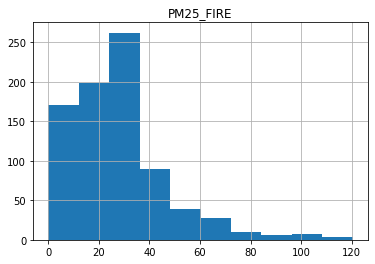

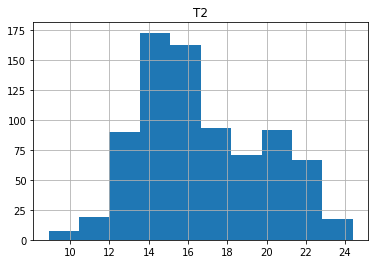

In [ ]:
df_simulaciones.hist("PM25_FIRE")
df_observaciones.hist('T2')

In [ ]:
print(df_simulaciones.head(1), df_simulaciones.tail(1))
print(df_observaciones.head(1), df_observaciones.tail(1))
print("******")
df_observaciones.iloc[761]

                     PM25_FIRE  PM25_NOFIRE
2020-03-11 19:00:00        0.0          0.0                      PM25_FIRE  PM25_NOFIRE
2020-04-14 18:00:00  18.094244    11.567225
                     PM10   O3   CO  SO2  NO  NO2  NOX   WS     WD    T2  \
date                                                                       
2020-03-14 01:00:00  48.0  2.5  0.5  1.0 NaN  NaN  NaN  0.0  241.0  14.4   

                     Precipitacion  PM25  
date                                      
2020-03-14 01:00:00            0.0  30.0               PM10   O3   CO  SO2    NO   NO2   NOX   WS     WD    T2  \
date                                                                  
2020-04-16  90.0  4.0  0.8  1.2  31.0  23.8  54.7  0.4  131.0  13.8   

            Precipitacion  PM25  
date                             
2020-04-16            0.0  37.0  
******


PM10              17.0
O3                25.2
CO                 0.6
SO2                2.0
NO                 8.9
NO2                9.2
NOX               18.1
WS                 2.1
WD               249.0
T2                18.8
Precipitacion      0.0
PM25              11.0
Name: 2020-04-14 18:00:00, dtype: float64

762


762

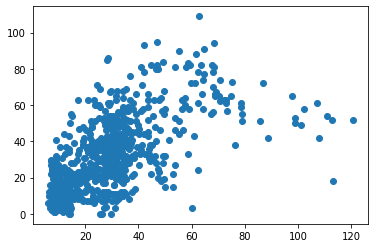

In [ ]:
matplotlib.pyplot.scatter(df_simulaciones.PM25_FIRE[54:], df_observaciones.PM25[:762])
print(len(df_simulaciones.PM25_FIRE[54:]))
len(df_observaciones.PM25[:762])

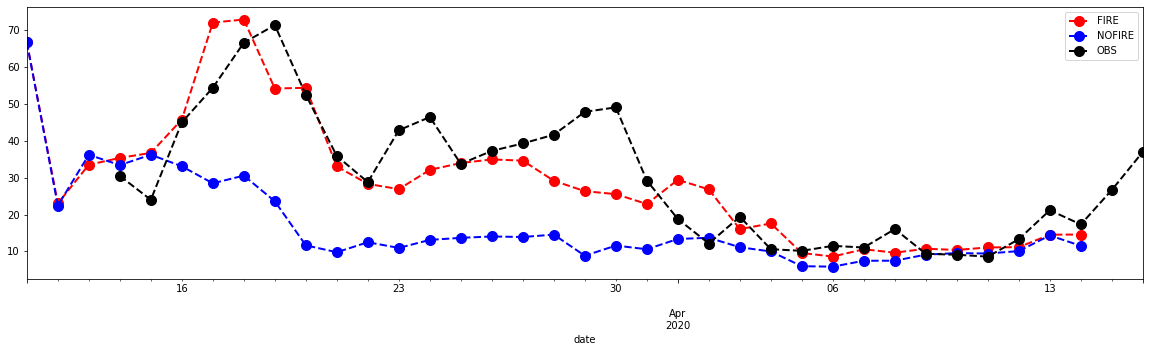

In [ ]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20,5))

df_simulaciones['PM25_FIRE'].resample('D').mean().plot(ax=ax, kind='line', style='--o', markersize=10, color='r', linewidth=2, label='FIRE')
df_simulaciones['PM25_NOFIRE'].resample('D').mean().plot(ax=ax, kind='line', style='--o', markersize=10, color='b', linewidth=2, label='NOFIRE')

# Colocar el nombre de la variable
df_observaciones['PM25'].resample('D').mean().plot(ax=ax, kind='line', style='--o', markersize=10, color='k', linewidth=2, label='OBS')
ax.legend().set_visible(True)

matplotlib.pyplot.savefig("/gdrive/My Drive/Colab Notebooks/Taller_WRF/Imagenes/GraficaTemporal_PM25.png", dpi=100, bbox_inches='tight', transparent=True)


# Gráfica Temporal Dirección y Velocidad del Viento

In [ ]:
# Abrir el archivo que vamos a usar para graficar.

# Para la rosa de vientos necesitamos los datos de dirección y velocidad.
datos = Dataset("/gdrive/My Drive/Colab Notebooks/Taller_WRF/data/datos_taller_wrf_FIRE.nc") # Escenario FIRE
WIND = (wrf.g_uvmet.get_uvmet_wspd_wdir(datos, wrf.ALL_TIMES, squeeze=True, cache=None, meta=True,_key=None, units='m s-1'))

# Velocidad del viento en m/s
WS_FIRE = WIND[0,0:816,cel_lat,cel_lon]

# Dirección del viento en grados.
WD_FIRE = WIND[1,0:816,cel_lat,cel_lon]



# Para la rosa de vientos necesitamos los datos de dirección y velocidad.
datos = Dataset("/gdrive/My Drive/Colab Notebooks/Taller_WRF/data/datos_taller_wrf_NOFIRE.nc") # Escenario FIRE
WIND = (wrf.g_uvmet.get_uvmet_wspd_wdir(datos, wrf.ALL_TIMES, squeeze=True, cache=None, meta=True,_key=None, units='m s-1'))

# Velocidad del viento en m/s
WS_NOFIRE = WIND[0,0:816,cel_lat,cel_lon]

# Dirección del viento en grados.
WD_NOFIRE = WIND[1,0:816,cel_lat,cel_lon]


# Llamar las fechas 
Times = wrf.extract_times(datos, timeidx=wrf.ALL_TIMES, method="cat", squeeze=True, cache=None, meta=False,do_xtime=False)
Fechas =  Times[0:816] - pandas.Timedelta(hours=5)


# Crear un data frame con los datos
df_simulaciones = pandas.DataFrame.from_records({"WS_FIRE": WS_FIRE, "WS_NOFIRE": WS_NOFIRE, "WD_FIRE": WD_FIRE, "WD_NOFIRE": WD_NOFIRE}, index=Fechas[0:816])
print(df_simulaciones)


# Dirección del Viento

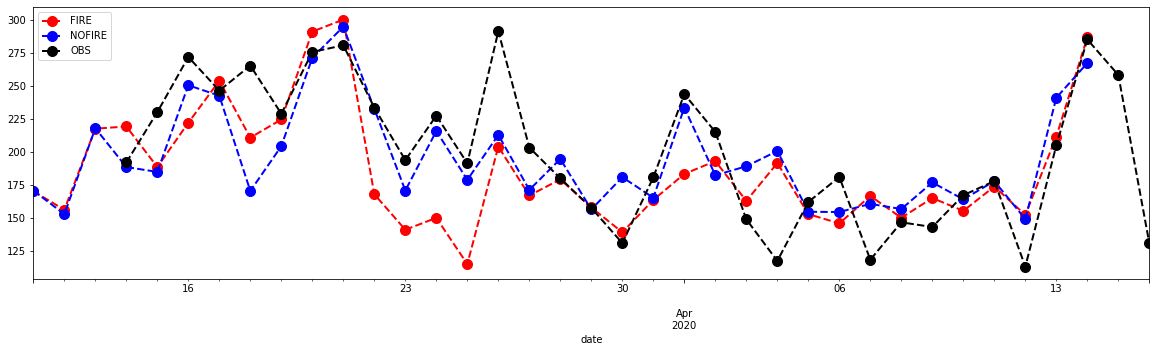

In [ ]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20,5))

df_simulaciones['WD_FIRE'].resample('D').mean().plot(ax=ax, kind='line', style='--o', markersize=10, color='r', linewidth=2, label='FIRE')
df_simulaciones['WD_NOFIRE'].resample('D').mean().plot(ax=ax, kind='line', style='--o', markersize=10, color='b', linewidth=2, label='NOFIRE')

# Colocar el nombre de la variable
df_observaciones['WD'].resample('D').mean().plot(ax=ax, kind='line', style='--o', markersize=10, color='k', linewidth=2, label='OBS')
ax.legend().set_visible(True)

matplotlib.pyplot.savefig("/gdrive/My Drive/Colab Notebooks/Taller_WRF/Imagenes/GraficaTemporal_WD.png", dpi=100, bbox_inches='tight', transparent=True)

# Velocidad del Viento

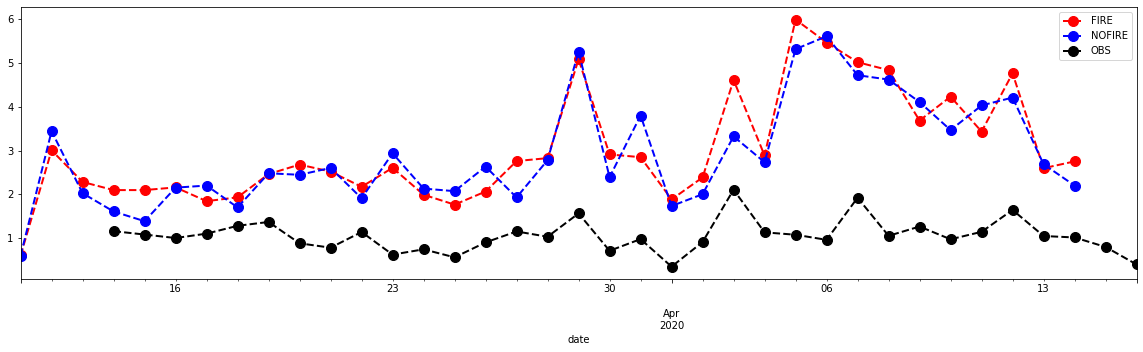

In [ ]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20,5))

df_simulaciones['WS_FIRE'].resample('D').mean().plot(ax=ax, kind='line', style='--o', markersize=10, color='r', linewidth=2, label='FIRE')
df_simulaciones['WS_NOFIRE'].resample('D').mean().plot(ax=ax, kind='line', style='--o', markersize=10, color='b', linewidth=2, label='NOFIRE')

# Colocar el nombre de la variable
df_observaciones['WS'].resample('D').mean().plot(ax=ax, kind='line', style='--o', markersize=10, color='k', linewidth=2, label='OBS')
ax.legend().set_visible(True)

matplotlib.pyplot.savefig("/gdrive/My Drive/Colab Notebooks/Taller_WRF/Imagenes/GraficaTemporal_WS.png", dpi=100, bbox_inches='tight', transparent=True)